In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.constants import c

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.facecolor'] = 'w'

Steps:
1 - Load EME reflection frequency data
2 - Load Spacecraft frequency data
3 - Load JPL Horizons range rate data for the centre of moon and me
4 - Load JPL Horizons range rate data for the centre of moon and Goldstone (DSS26)
5 - Interpolate the EME reflection data with the JPL Horizons range rate data for the centre of moon and me data
6 - Interpolate the EME reflection data with the JPL Horizons range rate data for the centre of moon and Goldstone
7 - Determine the transmit frequency by calculating ft = fr * (c + Vt) * (c + Vr) / C^2
8 - Plot results

Future steps:
9 - Perform 3-way Doppler analysis with GMAT and recalculate the difference in turnaround ratio accounting for spacecraft trajectory.

In [2]:
#Load raw lunar reflection frequency data
up_data = np.fromfile('/media/scott/fast/ch3_2way/ch3_up.dat', sep = ' ').reshape((-1,4))
t_up_data = Time(up_data[:,0], format = 'mjd')
freq_up_data = up_data[:,1]
amp_up_data = up_data[:,2]

In [3]:
#Load raw downlink from spacecraft frequency data
down_data = np.fromfile('/media/scott/fast/ch3_2nd_db/ch3_down.dat', sep = ' ').reshape((-1,4))
t_down_data = Time(down_data[:,0], format = 'mjd')
freq_down_data = down_data[:,1]
amp_down_data = down_data[:,2]

In [4]:
#Load JPL Horizons Moon to me data.
gmd_file = '/home/scott/Dropbox/satobs/ch3/moon_to_8049.txt'
gmd_mjd = []
gmd_rangerate = []
with open(gmd_file) as f:
    for l in f.readlines()[0:]:
        gmd_mjd.append(float(l.split()[0]))
        gmd_rangerate.append(float(l.split()[-1]))
gmd_mjd = np.array(gmd_mjd)
gmd_mjd = gmd_mjd - 2400000.5
gmd_rangerate = np.array(gmd_rangerate)

#NOTE: 2022-12-09 - Found that this piece of code was set to scale = 'tai'! Changing this to 'utc' fixed the parobolic curve shape of the residuals and flattened them out.  I believe GMAT outputs TAI and Horizons UTC.
t_gmd = Time(gmd_mjd , scale = 'utc', format = 'mjd')

In [5]:
#JPL Horizons Moon to Goldstone data.
gmd_file2 = '/home/scott/Dropbox/satobs/ch3/moon_to_goldstone.txt'
gmd_mjd2 = []
gmd_rangerate2 = []
with open(gmd_file2) as f:
    for l in f.readlines()[0:]:
        gmd_mjd2.append(float(l.split()[0]))
        gmd_rangerate2.append(float(l.split()[-1]))
gmd_mjd2 = np.array(gmd_mjd2)
gmd_mjd2 = gmd_mjd2 - 2400000.5
gmd_rangerate2 = np.array(gmd_rangerate2)

#NOTE: 2022-12-09 - Found that this piece of code was set to scale = 'tai'! Changing this to 'utc' fixed the parobolic curve shape of the residuals and flattened them out.  I believe GMAT outputs TAI and Horizons UTC.
t_gmd2 = Time(gmd_mjd2 , scale = 'utc', format = 'mjd')

In [6]:
#Interpolate JPL data to my frequency data
rangerate_interp = np.interp(t_up_data.utc.mjd, t_gmd.utc.mjd, gmd_rangerate)


In [7]:
#Interpolate JPL data to my frequency data
rangerate2_interp = np.interp(t_up_data.utc.mjd, t_gmd2.utc.mjd, gmd_rangerate2)


In [8]:
#Determine freq_transmit
freq_transmit = (freq_up_data * ((c + rangerate2_interp*1e3) * (c + rangerate_interp*1e3))) / (c*c)

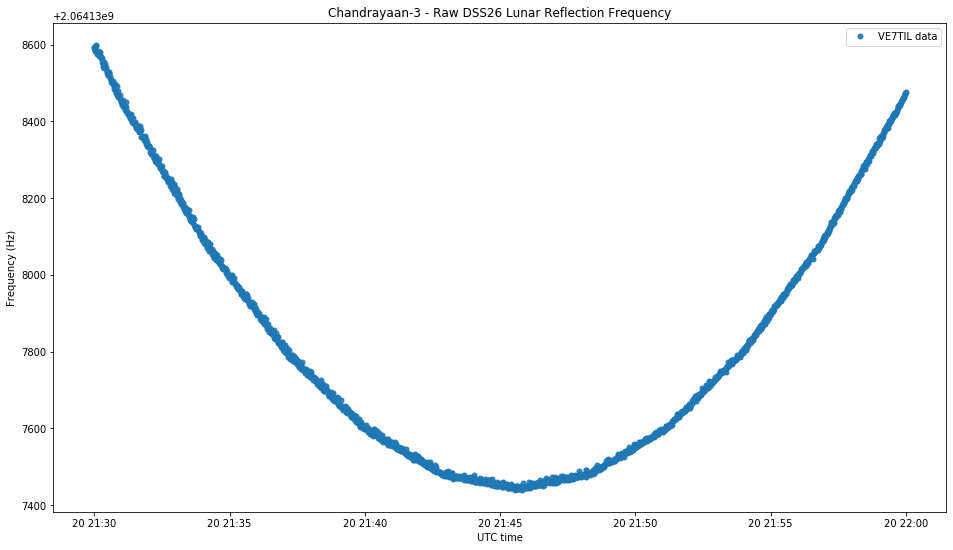

In [14]:
plt.plot(t_up_data.datetime,freq_up_data,'.',markersize=10, alpha=25, label = 'VE7TIL data')
plt.title('Chandrayaan-3 - Raw DSS26 Lunar Reflection Frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend();
plt.show();

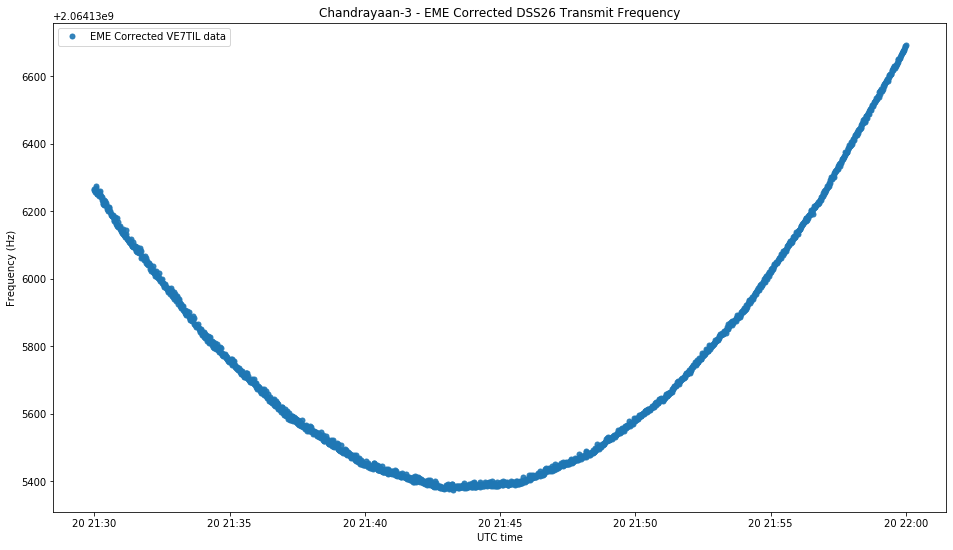

In [15]:
plt.plot(t_up_data.datetime,freq_transmit,'.',markersize=10, alpha=25, label = 'EME Corrected VE7TIL data')
plt.title('Chandrayaan-3 - EME Corrected DSS26 Transmit Frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend();
plt.show();

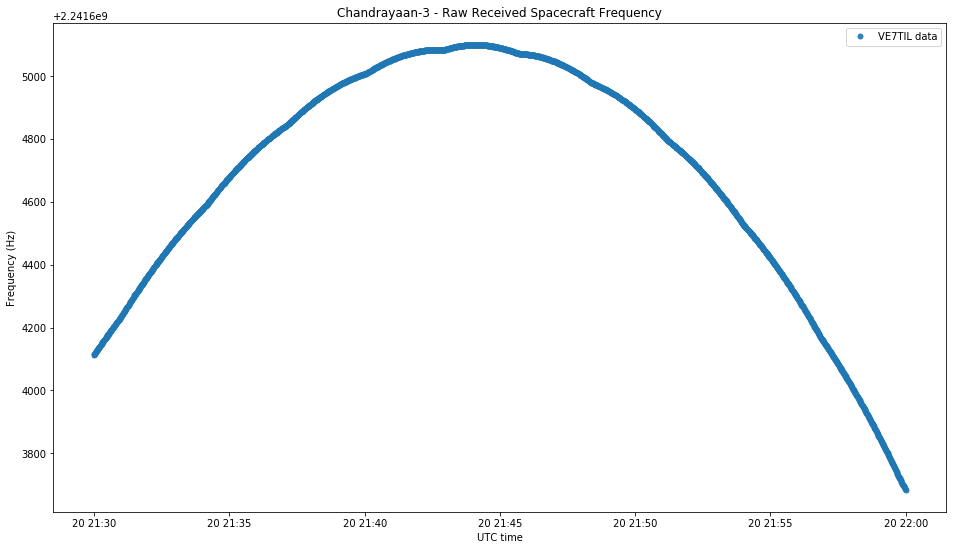

In [16]:
plt.plot(t_up_data.datetime,freq_down_data,'.',markersize=10, alpha=25, label = 'VE7TIL data')
plt.title('Chandrayaan-3 - Raw Received Spacecraft Frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('UTC time')
plt.legend();
plt.show();

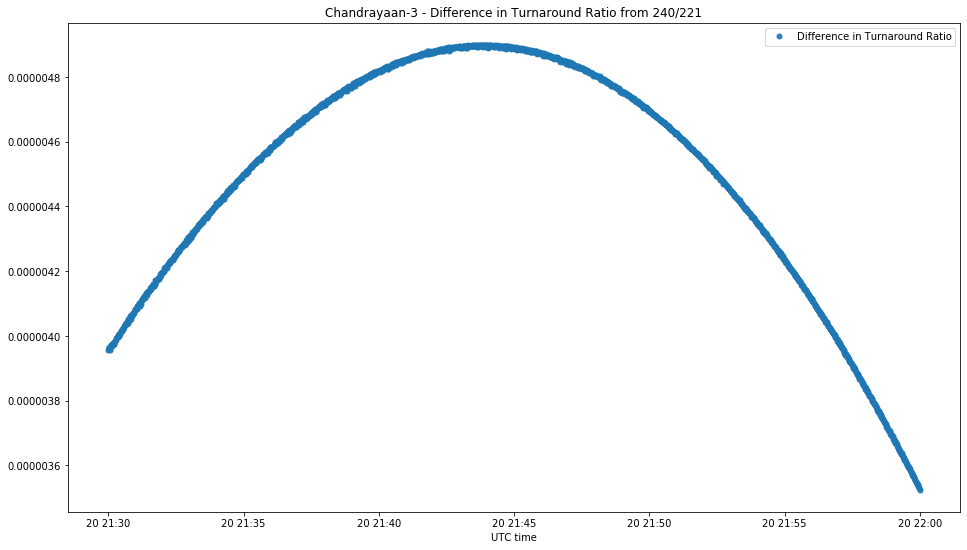

In [20]:
turnaround_ratio = freq_down_data / freq_transmit
plt.plot(t_up_data.datetime,turnaround_ratio - (240/221),'.',markersize=10, alpha=25, label = 'Difference in Turnaround Ratio')
plt.title('Chandrayaan-3 - Difference in Turnaround Ratio from 240/221')
plt.ylabel('')
plt.xlabel('UTC time')
plt.legend();
plt.show();